<a href="https://colab.research.google.com/github/SarahMcEliece/DTSA-5511-Deep-Learning/blob/main/Week4_Disaster_Kaggle/Week_4_Kaggle_project_Disaster_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA 5511 Week 3 Mini Project
# Cancer Image Classification

For week 3 of deep learning, I will create a CNN model to identify metisttic cancer. This is a kaggle competiotion, described as:

> Indented block
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.




In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns


plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

# Pulling and preprocessing data
First I need to get the data from kaggle, see what format it is in and do some pre-processing.

In [4]:
##Setup pulling data from kaggle
#dowload api token from kaggle profile and upload it to notebook

! pip install kaggle
! mkdir /content/.kaggle
! cp /kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download nlp-getting-started
! unzip nlp-getting-started.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/content/.kaggle’: File exists
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nlp-getting-started.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
tweets = pd.read_csv('train.csv')
print(tweets.info())
print(tweets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


There is definitely some cleaning to be done, but not a ton right now I'm going to make everything lower and clean up a little puctuation.

In [6]:
def clean_str(x):
    #source https://www.kaggle.com/code/hamishdickson/using-keras-oov-tokens
    x = str(x)
    x = x.lower()
    
    specials = [',', '?']
    for s in specials:
        x = x.replace(s, f' {s} ')
        
    return x

tweets['text'] = tweets['text'].apply(clean_str)

Now I'm going to make this into one giant corpus to visualize some word frequencies and get a sense of how long my tweets are.

Max tweet word length:  71


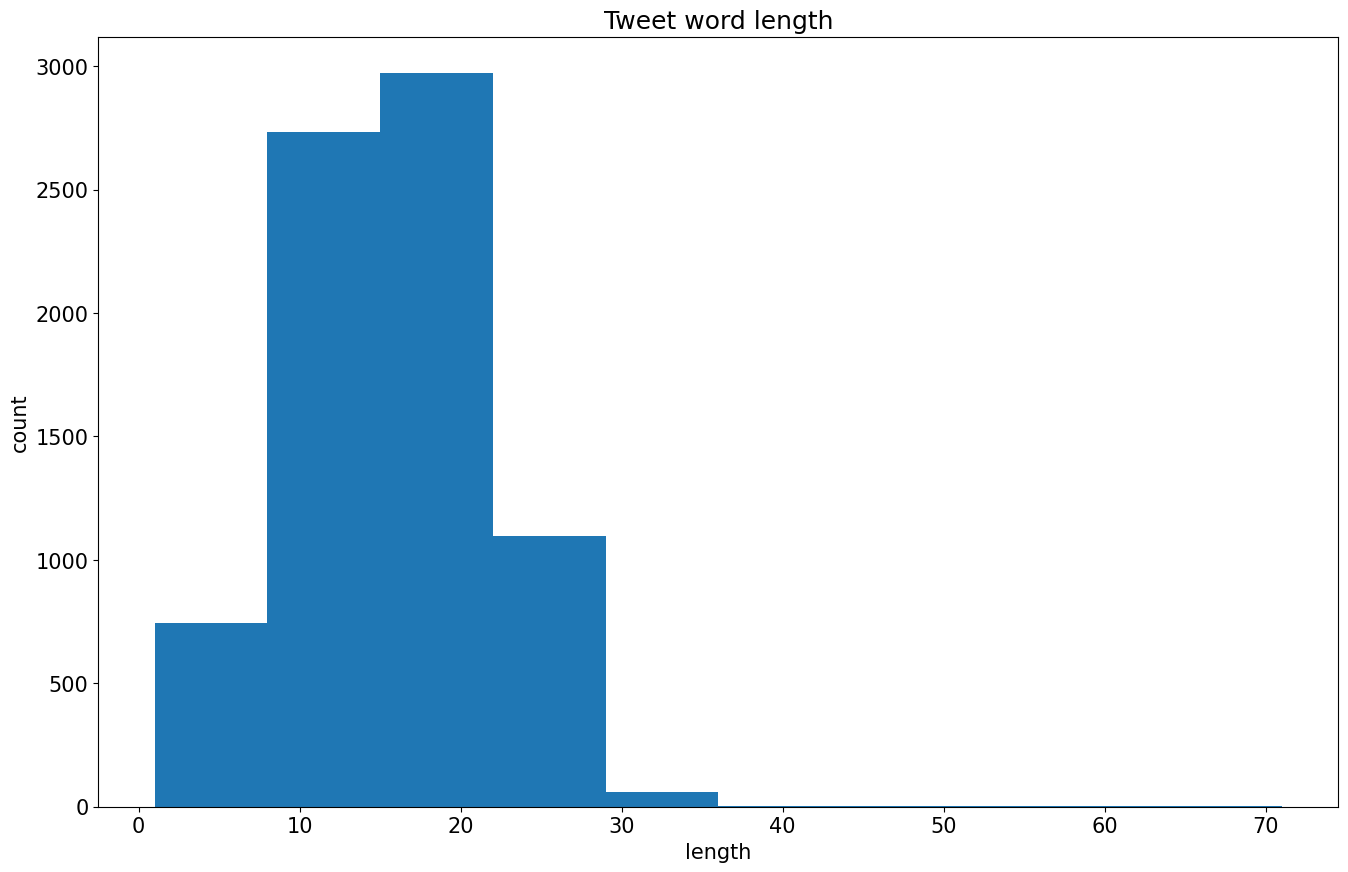

In [7]:
tweet_len = [len(x.split()) for x in tweets['text']]
print("Max tweet word length: ",max(tweet_len))
plt.hist(tweet_len)
plt.title('Tweet word length')
plt.ylabel('count')
plt.xlabel('length')
plt.show()

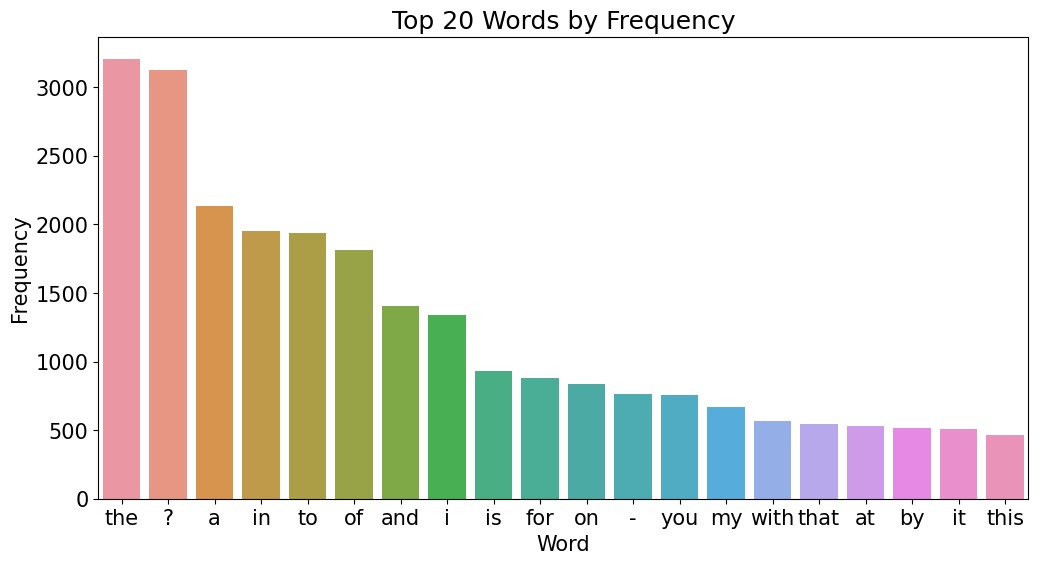

In [8]:
# create word frequency graph
word_freq = {}
for text in tweets['text']:
    for word in text.split():
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

# sort words by frequency and plot top 20
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:20]
x, y = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(x),y=list(y))
plt.title("Top 20 Words by Frequency")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

These are all stopwords I would remove if I were doing other unsupervised methods for example. I'm going to trust the process.

In [9]:
1 - tweets['target'].mean()

0.5703402075397347

Importantly, we observe 57% of tweets are not disaster tweets. Because I did not make my dataset balanced, 57% will be my baseline accuracy- or the accuracy I would achieve if I predicted all tweets were not about disasters.

Now I'm going to do some NLP pre-processing. All the previous NLP work I've done has benifited from stemming and removing stopwords, but from what I've read this isn't really neccesary for RNN. So, I'll just be tokenizing and creating sequences. Since tweets are already a pretty controlled length, I don't think I need to split them any furter. I will, however pad out my tweets to all be the same length.

In [10]:
# tokenize the text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(tweets['text'])

# convert text to sequences
sequences = tokenizer.texts_to_sequences(tweets['text'])

# pad the sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=100)

Lastly, I'm going to split into training and validation data.

In [11]:
from sklearn.model_selection import train_test_split
train, val, train_labels, val_labels = train_test_split(padded_sequences, tweets['target'], test_size=0.2, random_state=1)

### Building Neural network.
The first thing I'm going to do is try a  simple model with two LSTM layers. Mostly, just to make sure I'm doing this even rempotely correct. 

In [59]:
# Build Sequential Model
model = keras.Sequential([
    keras.layers.Embedding(input_dim=100, output_dim=32, input_length=100),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           3200      
                                                                 
 lstm_10 (LSTM)              (None, 100, 64)           24832     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 40,481
Trainable params: 40,481
Non-trainable params: 0
_________________________________________________________________


### Model fit


In [61]:
batch_size = 35
history = model.fit(
        train, train_labels,
        steps_per_epoch=len(train) // batch_size,
        epochs=100,
        validation_data=[val, val_labels],
        validation_steps=len(val) // batch_size)

Epoch 1/100
174/174 [==============================] - 21s 100ms/step - loss: 0.6273 - accuracy: 0.6461 - val_loss: 0.5802 - val_accuracy: 0.7131
Epoch 2/100
174/174 [==============================] - 6s 34ms/step - loss: 0.5712 - accuracy: 0.7140 - val_loss: 0.5664 - val_accuracy: 0.7144
Epoch 3/100
174/174 [==============================] - 5s 28ms/step - loss: 0.5607 - accuracy: 0.7164 - val_loss: 0.5577 - val_accuracy: 0.7183
Epoch 4/100
174/174 [==============================] - 3s 15ms/step - loss: 0.5558 - accuracy: 0.7210 - val_loss: 0.5597 - val_accuracy: 0.7223
Epoch 5/100
174/174 [==============================] - 2s 12ms/step - loss: 0.5531 - accuracy: 0.7255 - val_loss: 0.5529 - val_accuracy: 0.7229
Epoch 6/100
174/174 [==============================] - 3s 17ms/step - loss: 0.5683 - accuracy: 0.7108 - val_loss: 0.5556 - val_accuracy: 0.7203
Epoch 7/100
174/174 [==============================] - 3s 17ms/step - loss: 0.5543 - accuracy: 0.7195 - val_loss: 0.5516 - val_accurac

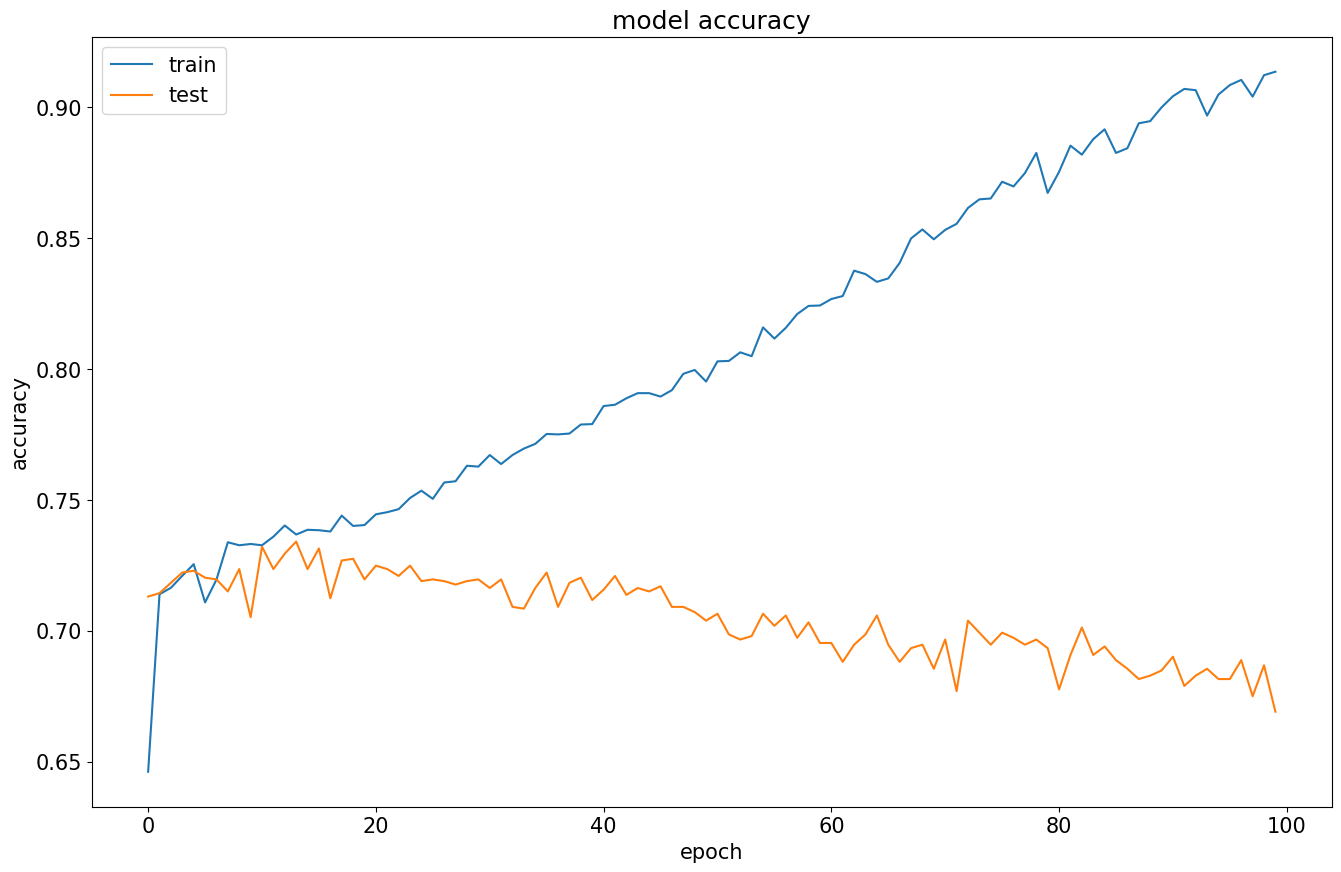

In [62]:
#Let's graph this mess
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# WOW! We overfit that by a lot!
So definitely a lot to improve here. Learning rate needs to go way down, we started overfitting around epoch 7. That also means we need to add some regularization. Unsurpising.

Epoch 1/100
174/174 [==============================] - 24s 106ms/step - loss: 0.6790 - accuracy: 0.5680 - val_loss: 0.6601 - val_accuracy: 0.5791
Epoch 2/100
174/174 [==============================] - 7s 38ms/step - loss: 0.6378 - accuracy: 0.6594 - val_loss: 0.5795 - val_accuracy: 0.7413
Epoch 3/100
174/174 [==============================] - 4s 24ms/step - loss: 0.4904 - accuracy: 0.7878 - val_loss: 0.4681 - val_accuracy: 0.7925
Epoch 4/100
174/174 [==============================] - 4s 26ms/step - loss: 0.3904 - accuracy: 0.8458 - val_loss: 0.4649 - val_accuracy: 0.7925
Epoch 5/100
174/174 [==============================] - 5s 30ms/step - loss: 0.3396 - accuracy: 0.8742 - val_loss: 0.4816 - val_accuracy: 0.7912
Epoch 6/100
174/174 [==============================] - 4s 23ms/step - loss: 0.3014 - accuracy: 0.8903 - val_loss: 0.4924 - val_accuracy: 0.7984
Epoch 7/100
174/174 [==============================] - 4s 22ms/step - loss: 0.2737 - accuracy: 0.9025 - val_loss: 0.5579 - val_accurac

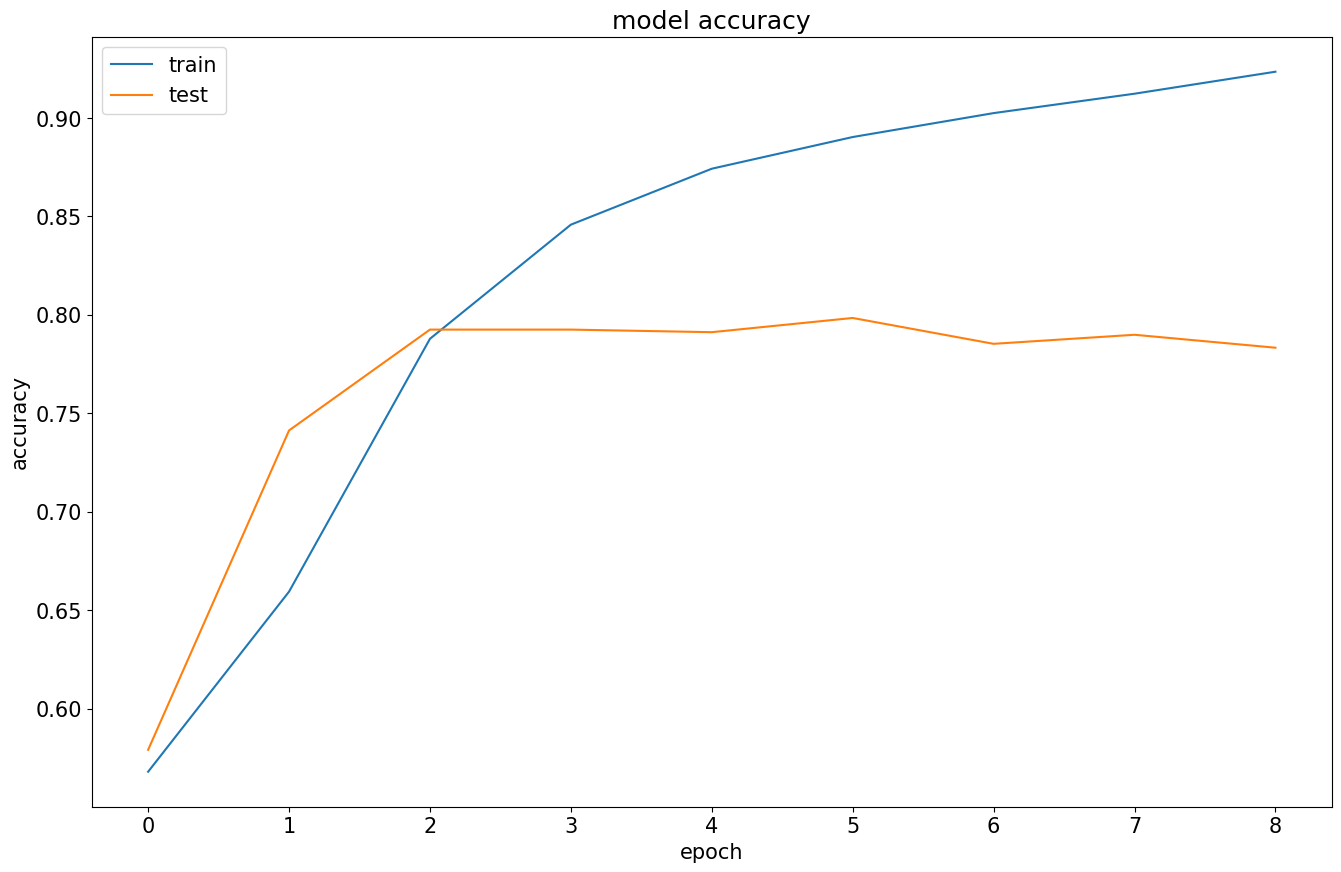

In [65]:
#Updated learning rate from .001 to .0001, add some more layers as well as dropouts, add early stopping
batch_size = 35

# Build Sequential Model
model2 = keras.Sequential([
    keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=100),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(32),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history2 = model2.fit(
        train, train_labels,
        steps_per_epoch=len(train) // batch_size,
        epochs=100,
        validation_data=[val, val_labels],
        validation_steps=len(val) // batch_size,
        callbacks=[early_stopping])

#Let's graph this mess
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Much Better! 

We still overfit pretty quick, but I think it's time to play around more with the model format. Honestly, a validation accuracy around .8 isn't terrible for how little training have been done. 

Epoch 1/100
174/174 [==============================] - 32s 147ms/step - loss: 0.6871 - accuracy: 0.5489 - val_loss: 0.6813 - val_accuracy: 0.5791
Epoch 2/100
174/174 [==============================] - 7s 38ms/step - loss: 0.6585 - accuracy: 0.6005 - val_loss: 0.6429 - val_accuracy: 0.5968
Epoch 3/100
174/174 [==============================] - 5s 27ms/step - loss: 0.6071 - accuracy: 0.6877 - val_loss: 0.6598 - val_accuracy: 0.6612
Epoch 4/100
174/174 [==============================] - 6s 37ms/step - loss: 0.5442 - accuracy: 0.7524 - val_loss: 0.6125 - val_accuracy: 0.7262
Epoch 5/100
174/174 [==============================] - 4s 20ms/step - loss: 0.4823 - accuracy: 0.7921 - val_loss: 0.5382 - val_accuracy: 0.7544
Epoch 6/100
174/174 [==============================] - 4s 20ms/step - loss: 0.4372 - accuracy: 0.8176 - val_loss: 0.5445 - val_accuracy: 0.7879
Epoch 7/100
174/174 [==============================] - 5s 27ms/step - loss: 0.3996 - accuracy: 0.8392 - val_loss: 0.5194 - val_accurac

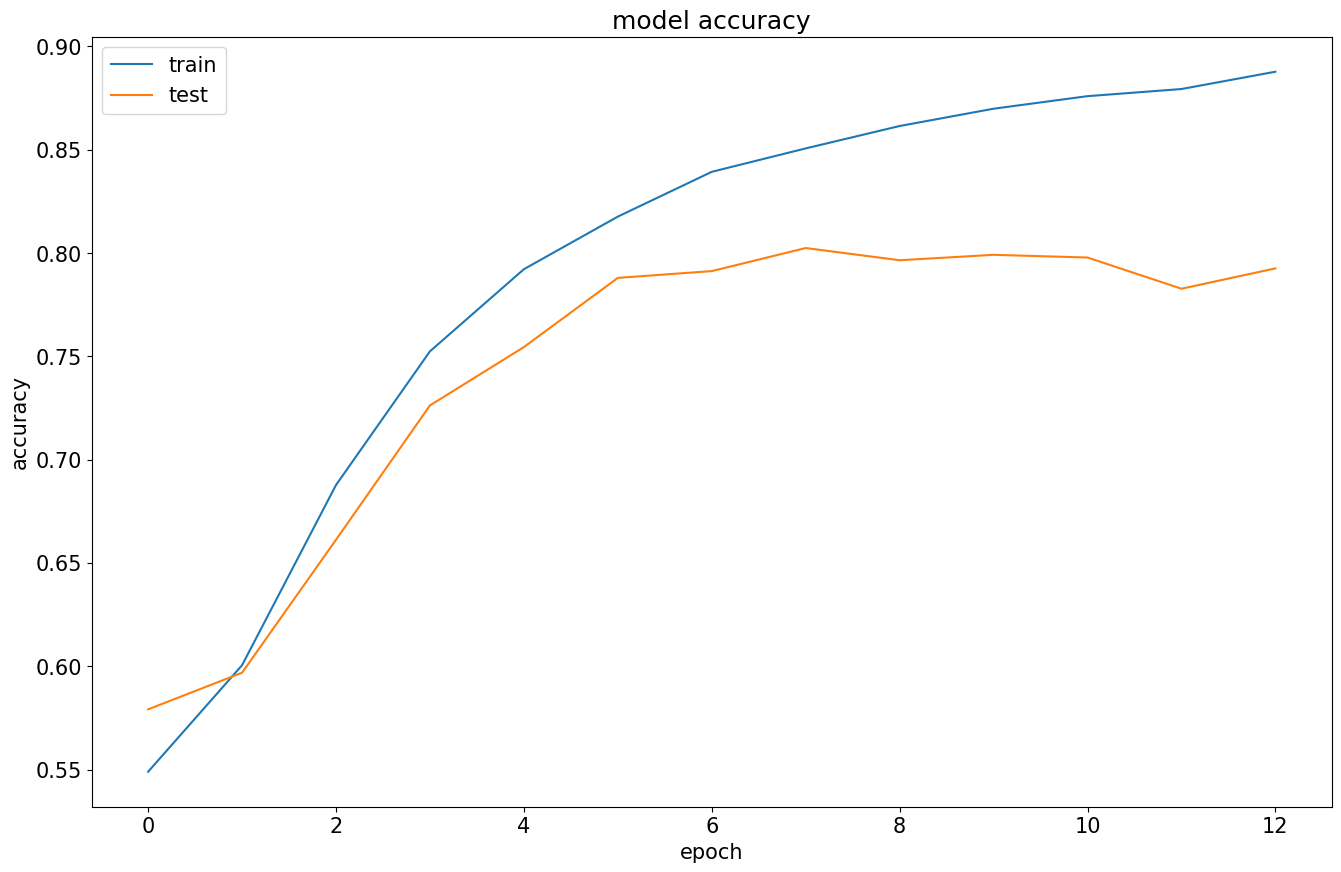

In [17]:
#LSTM has a dropout parameter?
batch_size = 35

# Build Sequential Model
model3 = keras.Sequential([
    keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=100),
    keras.layers.LSTM(128, return_sequences=True, dropout=0.5),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(64, return_sequences=True, dropout=0.5),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(32, dropout=0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history3 = model3.fit(
        train, train_labels,
        steps_per_epoch=len(train) // batch_size,
        epochs=100,
        validation_data=[val, val_labels],
        validation_steps=len(val) // batch_size,
        callbacks=[early_stopping])

#Let's graph this mess
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Well, this was almost identical. I also just realized I should probably be using GRU layers not LSTM layers since my dataset is small 🤦 I'll try the same thing, but with GRU.

Epoch 1/100
174/174 [==============================] - 36s 152ms/step - loss: 0.6763 - accuracy: 0.5734 - val_loss: 0.6422 - val_accuracy: 0.6691
Epoch 2/100
174/174 [==============================] - 6s 36ms/step - loss: 0.6022 - accuracy: 0.6979 - val_loss: 0.5253 - val_accuracy: 0.7603
Epoch 3/100
174/174 [==============================] - 4s 22ms/step - loss: 0.4253 - accuracy: 0.8156 - val_loss: 0.4599 - val_accuracy: 0.7932
Epoch 4/100
174/174 [==============================] - 5s 27ms/step - loss: 0.3491 - accuracy: 0.8632 - val_loss: 0.4653 - val_accuracy: 0.7978
Epoch 5/100
174/174 [==============================] - 3s 19ms/step - loss: 0.3043 - accuracy: 0.8821 - val_loss: 0.4991 - val_accuracy: 0.7761
Epoch 6/100
174/174 [==============================] - 4s 24ms/step - loss: 0.2657 - accuracy: 0.8992 - val_loss: 0.5372 - val_accuracy: 0.7840
Epoch 7/100
174/174 [==============================] - 4s 22ms/step - loss: 0.2330 - accuracy: 0.9138 - val_loss: 0.5708 - val_accurac

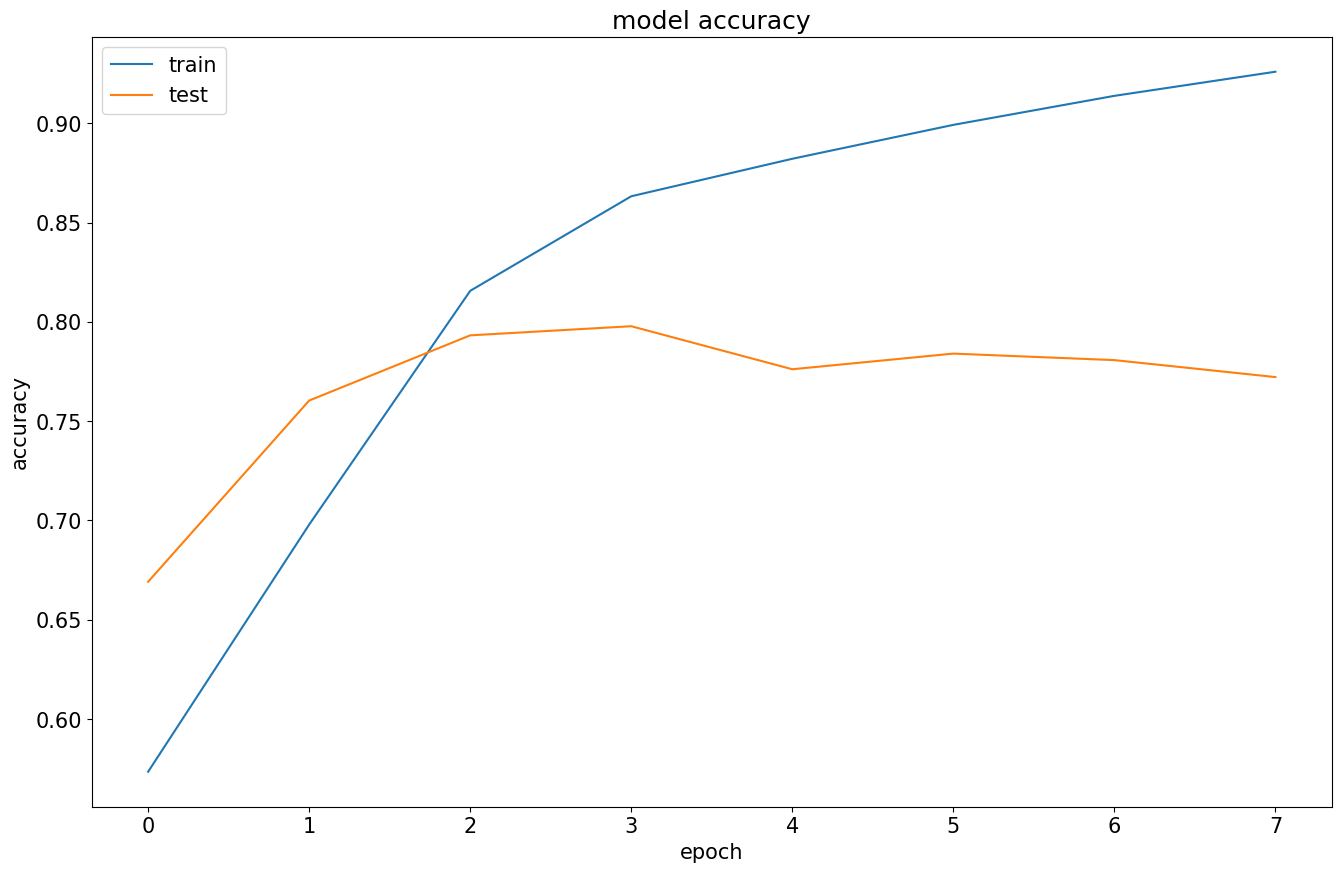

In [12]:
#Updated learning rate from .001 to .0001, add some more layers as well as dropouts, add early stopping
batch_size = 35

# Build Sequential Model
model4 = keras.Sequential([
    keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=100),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(32),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history4 = model4.fit(
        train, train_labels,
        steps_per_epoch=len(train) // batch_size,
        epochs=100,
        validation_data=[val, val_labels],
        validation_steps=len(val) // batch_size,
        callbacks=[early_stopping])

#Let's graph this mess
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

ANNND it looks almost identical. I think I'm going to decreace my batch size hoping training will take a bit longer and overfitting will be slower. Then I will give up.

In [13]:
#Updated batch size
batch_size = 20

# Same Model
model5 = keras.Sequential([
    keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=100),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(32),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])


history5 = model5.fit(
        train, train_labels,
        steps_per_epoch=len(train) // batch_size,
        epochs=100,
        validation_data=[val, val_labels],
        validation_steps=len(val) // batch_size,
        callbacks=[early_stopping])

#Let's graph this mess
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
302/304 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.5948

304/304 [==============================] - 37s 104ms/step - loss: 0.6614 - accuracy: 0.5948 - val_loss: 0.6208 - val_accuracy: 0.6973
Epoch 2/100
303/304 [============================>.] - ETA: 0s - loss: 0.5188 - accuracy: 0.7638

304/304 [==============================] - 6s 18ms/step - loss: 0.5180 - accuracy: 0.7643
Epoch 3/100
301/304 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8450

304/304 [==============================] - 6s 20ms/step - loss: 0.3783 - accuracy: 0.8451
Epoch 4/100
304/304 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8791

304/304 [==============================] - 5s 17ms/step - loss: 0.3167 - accuracy: 0.8791
Epoch 5/100
304/304 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8947

304/304 [==============================] - 5s 17ms/step - loss: 0.2781 - accuracy: 0.8947
Epoch 6/100
303/304 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9114

304/304 [==============================] - 5s 15ms/step - loss: 0.2448 - accuracy: 0.9115
Epoch 7/100
304/304 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9262

304/304 [==============================] - 4s 14ms/step - loss: 0.2028 - accuracy: 0.9262
Epoch 8/100
303/304 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9269

304/304 [==============================] - 6s 20ms/step - loss: 0.2002 - accuracy: 0.9272
Epoch 9/100
304/304 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9414

304/304 [==============================] - 5s 15ms/step - loss: 0.1710 - accuracy: 0.9414
Epoch 10/100
 99/304 [========>.....................] - ETA: 4s - loss: 0.1573 - accuracy: 0.9408

KeyboardInterrupt: ignored

# Training Summary and Conclusions
I began with a simple model to get my neural network legs that LSTM structure. From there based on the variation in the epoch-accuracy graphs noted in the analysis I made several more adjustments- lowered learning rate, added more  layers, used GRU rather than LSTM layers because of our small dataset, added normalization and dropout layers, and finally decreaced the batch size.

Overall I believe several tuning parameters were critical in improving my model:


*   Decreacing the learning rate to be able to accurately acess the issues with my model
*   Adding early stopping (for my own sanity)
*   Adding (large) dropout layers was they key to being able to generalize my model from training to validation

What didn't really work: most of it. Past my second model I didn't really see improvements from adding/rearranging layers

In the future I would try utilizing a prebuilt model to preprocess the text as well as see ho wpreprcessing the data with stop words and stemming for instances changed the model.




### Predicting Test Data
We have the model with trained weight. So we can evaluate our model performance with test data. Since test dataset is unseen data from model, so its accuracy and loss may be lower than training one.

In [15]:
test_labels_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [19]:
#upload test data labels
test_labels_df = pd.read_csv("/content/sample_submission.csv")
tweets_test = pd.read_csv('test.csv')

print("Number of tweets in our test data: ",len(test_labels_df))

# #Clean the test data
tweets_test['text'] = tweets_test['text'].apply(clean_str)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_test['text'])
sequences = tokenizer.texts_to_sequences(tweets_test['text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# #predict
preds = model3.predict(padded_sequences,verbose=1)

Number of tweets in our test data:  3263
102/102 [==============================] - 1s 9ms/step


In [28]:
test_labels_df['target'] = (preds[:, 0]>.5).astype('int')
test_labels_df.to_csv('submission.csv', index=False)
test_labels_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1


I have no idea why my test accuracy is so different from my validation accuracy. It makes no sense. 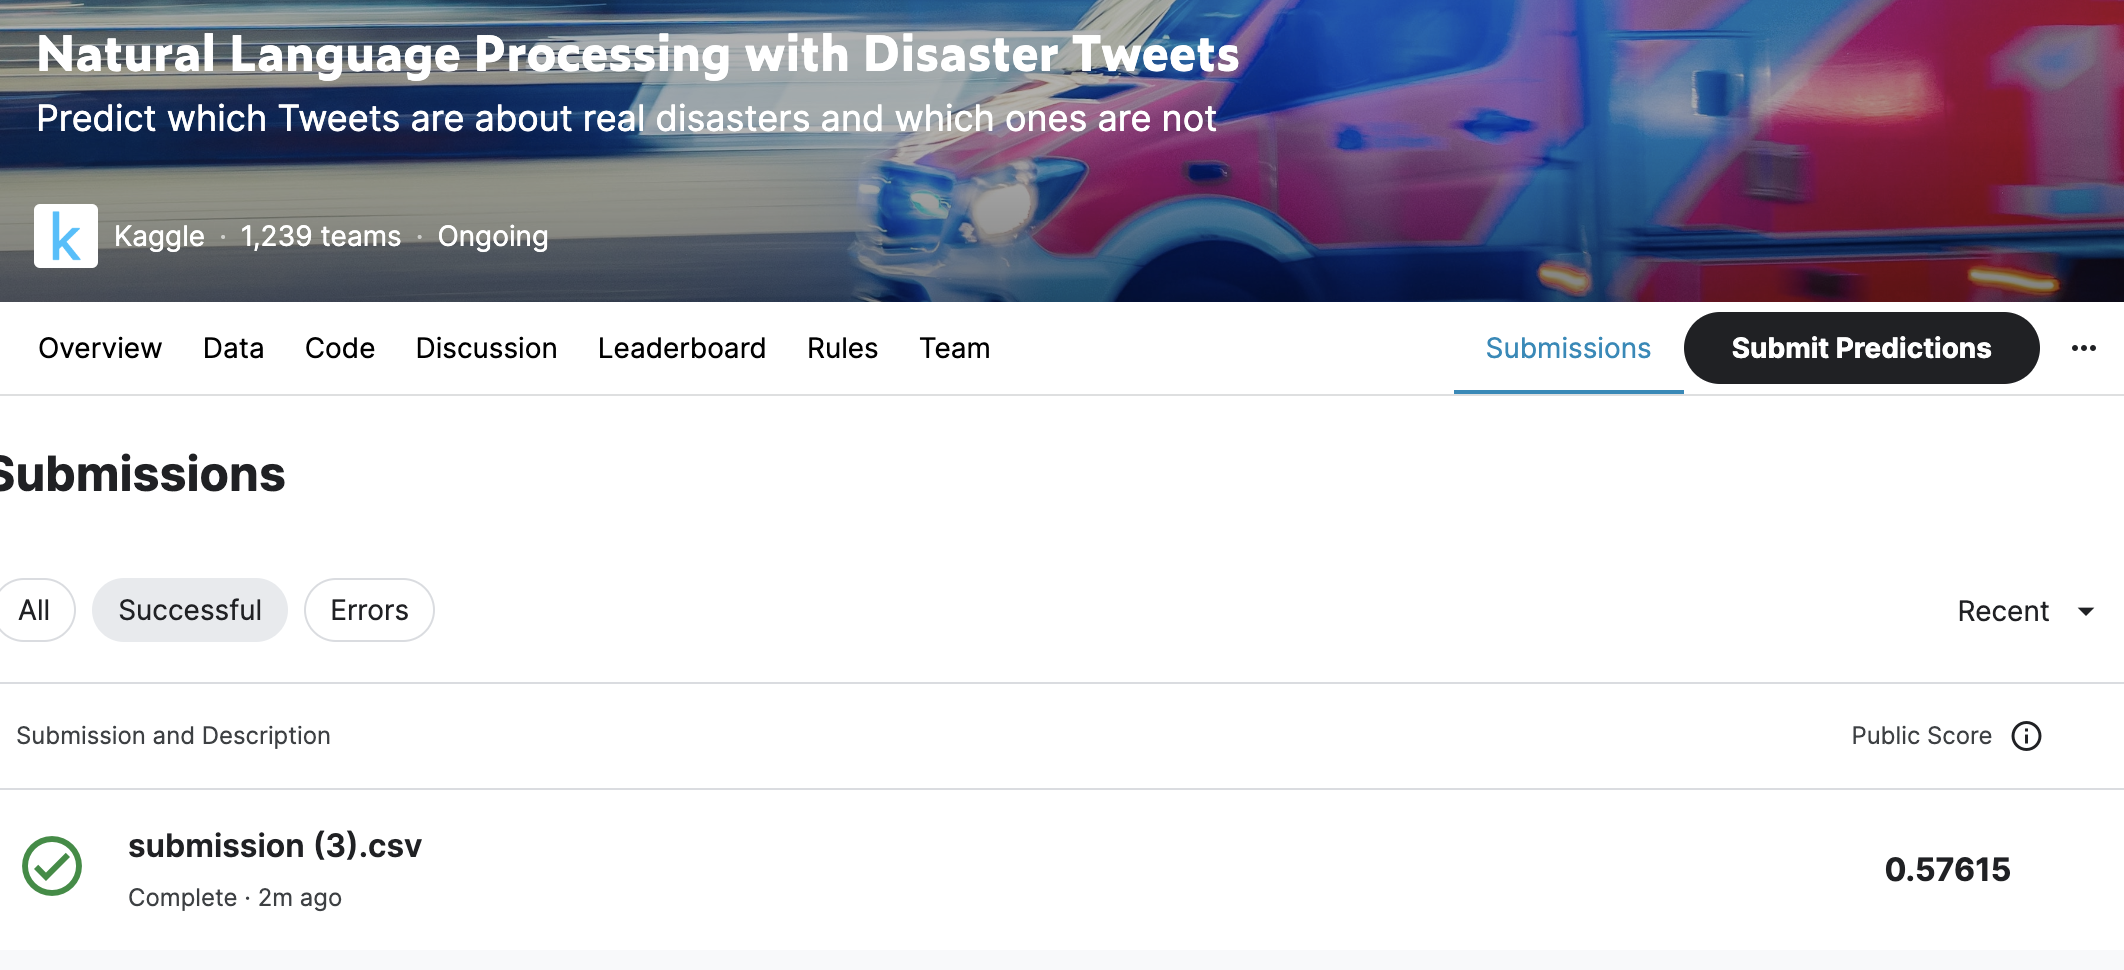